<a href="https://colab.research.google.com/github/sreent/machine-learning-from-scratch/blob/main/k_Nearest_Neighbours.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from itertools import product 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [32]:
class Metrics :
  def __init__(self) :
    """initialise distance compute engine"""
    self.metrics = {'accuracy': self.accuracy_score}

  def accuracy_score(self, y_true, y_pred) :
    """compute accuracy score from ground truth y_true and prediction y_pred"""
    return np.sum(y_true == y_pred) / len(y_true)

  def error_score(self, y_true, y_pred) :
    """compute error score from ground truth y_true and prediction y_pred"""
    return 1 - self.accuracy_score(y_true, y_pred)

  def precision_score(self, y_true, y_pred) :
    """compute precision score from ground truth y_true and prediction y_pred"""
    precision = []
    for label in list(set(list(y_pred))) :
      precision.append( np.sum(np.logical_and(y_test==y_pred, y_pred==label)) / len(y_pred[y_pred==label]) )

    return np.array(precision).mean()

  def recall_score(self, y_true, y_pred) :
    """compute recall score from ground truth y_true and prediction y_pred"""
    recall = []
    for label in list(set(list(y_pred))) :
      recall.append( np.sum(np.logical_and(y_true==y_pred, y_true==label)) / len(y_true[y_true==label]) )

    return np.array(recall).mean()

  def confusion_matrix(self, y_true, y_pred, labels=None) :
    """compute confusion matrix from ground truth y_true and prediction y_pred"""
    labels = list(set(list(y_true) + list(y_pred))) if labels is None else labels
    labels.sort()

    matrix = {}
    for prod in list(product(labels, repeat=2)) :
      matrix[prod] = np.sum(np.logical_and(y_true==prod[0], y_pred==prod[1]))

    return np.array(list(matrix.values())).reshape((len(labels), len(labels)))

  def get_score(self, y_true, y_pred, metric='accuracy') :
    """compute prediction score based on a give metric"""
    return self.metrics[metric](y_true, y_pred)

In [3]:
class Distances :
  def __init__(self) :
    """initialise distance compute engine"""
    self.metrics = {'euclidean': self.euclidean,
                    'manhattan': self.manhattan,
                    'cosine_similarity': self.cosine_similarity}

  def difference(self, x, y) :
    """compute difference between between set of vectors x and y"""
    return x.reshape(x.shape[0], 1, x.shape[1]) - y

  def dot(self, x, y) :
    """compute dot product between set of vectors x and y"""
    return np.sum(x.reshape(x.shape[0], 1, x.shape[1]) * y, axis=2)

  def pnorm(self, x, p) :
    """compute minkowski p-norm of a vector x"""
    return np.sum(np.abs(x)**p, axis=2)**(1/p)

  def euclidean(self, x, y) :
    """compute L2 Norm between vectors x and y"""
    return self.pnorm(self.difference(x, y), 2)

  def manhattan(self, x, y) :
    """compute L1 Norm between vectors x and y"""
    return self.pnorm(self.difference(x, y), 1)

  def cosine_similarity(self, x, y) :
    """compute Cosine Similarity between vectors x and y"""
    return 1 - self.dot(x, y) / (self.pnorm(x.reshape(x.shape[0], 1, x.shape[1]), 2) * self.pnorm(y.reshape(y.shape[0], 1, y.shape[1]), 2).T)

  def pairwise(self, x, y, metric='euclidean') :
    """compute pairwise distance between x and y using a given norm (metric)"""
    return self.metrics[metric](x, y)  

In [4]:
class NearestNeighbours :
  def __init__(self, k=None, metric='euclidean') :
    """initialise model, assign values to k and metric parameters"""
    self.k = k
    self.metric = metric

  def fit(self, X, y=None) :
    """direct assignment of training data to the model parameters (instantance based learning)"""
    self.X = X
    self.y = y

  def kneighbours(self, q, k=None, distance=True, label=False) :
    """given (a) query point(s), search for k neighbours"""
    k = self.k if k is None else k

    distances = Distances().pairwise(self.X, q, self.metric)
    indices = np.argsort(distances, axis=0)[:k,:]

    return_values = (self.X[indices,:], )
    if distance == True :
      return_values += (distances[indices], )

    if (label == True) & (self.y is not None) :
      return_values += (self.y[indices], )

    return return_values

  def predict(self, q, k=None) :
    """compute the majority class from k neighbours"""
    k = self.k if k is None else k

    neighbours, labels = self.kneighbours(q, k, distance=False, label=True)

    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=labels)

In [19]:
def train_test_split(X, y, test_size=0.3, shuffle=True, seed=204) :
  """split data into train and test sets with (1-test_size):(test_size) proportion"""

  indices = np.array([])
  if shuffle == True :
    p = np.random.RandomState(seed).uniform(0, 1, X.shape[0])
    indices = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=False, p=p/p.sum())
  else :
    indices = range(X.shape[0])

  size = int(np.ceil(X.shape[0]*(1-test_size)))
  samples = indices[:size]
  X_train, y_train = X[samples, :], y[samples]

  samples = indices[size:]
  X_test, y_test = X[samples, :], y[samples]

  return X_train, X_test, y_train, y_test

In [6]:
class GridSearchCV :
   def __init__(self, model=None, params={}, scoring='accuracy', cv=5) :
     """initialise model, assign values to k and metric parameters"""
     self.model = model
     self.params = params
     self.scoring = scoring
     self.cv = cv

   def fit(self, X, y) :
     """perform k-fold cross-validation. 
        finding best hyper-parameters and evaluating prediction performance 
        for each set of parameters and fold"""
     size = int( np.ceil(X.shape[0]/self.cv) )  
     folds = {k: {'min': k*size, 'max': (k+1)*size} for k in range(self.cv)}

     keys, values = zip(*self.params.items())
     evaluations = []
     for config in [dict(zip(keys, v)) for v in product(*values)] :
       scores = []
       confusion_matrices = []
       for (k, partition) in folds.items() :
         X_train, y_train = np.concatenate( (X[:partition['min'], :], X[partition['max']:, :]) ), np.concatenate( (y[:partition['min']], y[partition['max']:]) )
         X_test, y_test = X[partition['min']:partition['max'], :], y[partition['min']:partition['max']]
         
         self.model.__init__(**config)
         self.model.fit(X_train, y_train)
         
         y_pred = self.model.predict(X_test)
         scores.append( Metrics().get_score(y_test, y_pred, metric=self.scoring) )
         confusion_matrices.append( Metrics().confusion_matrix(y_test, y_pred) )
         
       evaluations.append( [config, np.mean(scores), scores, confusion_matrices] )
         
     evaluations = pd.DataFrame(data=evaluations, columns=['parameters', 'score', 'scores', 'confusion_matrices'])
     best = evaluations.sort_values(by=['score'], ascending=False).iloc[0]
     
     evaluations.rename({'score': 'average_' + self.scoring + '_score',
                         'scores': self.scoring + '_scores'}, axis='columns', inplace=True)
     
     self.evaluations = evaluations

     self.best_params, self.best_score = best.values[:2]

     self.model.__init__(**self.best_params)
     self.model.fit(X, y)

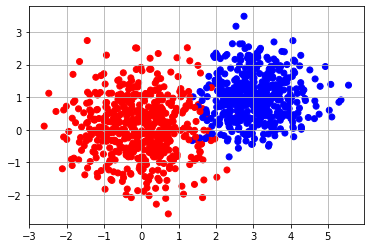

In [7]:
# simulated data - 2 classes
points = 1000
X, y = [], []
for i in range(points) :
  if np.random.random() > 0.5 :
    X.append([np.random.normal(0.0, 0.9), np.random.normal(0.0, 0.9)])
    y.append(0)

  else :
    X.append([np.random.normal(3.0, 0.7), np.random.normal(1.0, 0.7)])
    y.append(1)

X, y = np.array(X), np.array(y)

colors = ['red','blue']
plt.scatter(X[:,0], X[:,1], c=y, cmap=ListedColormap(colors))
plt.grid()
_ = plt.show()

In [20]:
# train-test split usage example
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, seed=204)

In [21]:
# k-NN usage examples
model = NearestNeighbours(k=3, metric='euclidean')
model.fit(X_train, y_train)
y_pred = model.predict(X_test, k=3)

In [33]:
# usage examples of accuracy, confusion metrics
print("accuracy:", Metrics().accuracy_score(y_test, y_pred))
print("error:", Metrics().error_score(y_test, y_pred))
print("precision:", Metrics().precision_score(y_test, y_pred))
print("recall:", Metrics().recall_score(y_test, y_pred))
print("confusion matrix:", Metrics().confusion_matrix(y_test, y_pred))

accuracy: 0.9766666666666667
error: 0.023333333333333317
precision: 0.9767628205128205
recall: 0.9765294771968853
confusion matrix: [[141   4]
 [  3 152]]


In [11]:
# cross validation usage example
params = {'k': list(range(1,20)),
          'metric': ['euclidean', 'manhattan']}
          
clf = GridSearchCV(NearestNeighbours(), params=params, scoring='accuracy', cv=5)
clf.fit(X, y)

In [12]:
clf.best_params, clf.best_score

({'k': 3, 'metric': 'euclidean'}, 0.986)

In [13]:
clf.evaluations.head()

,parameters,average_accuracy_score,accuracy_scores,confusion_matrices
0,"{'k': 1, 'metric': 'euclidean'}",0.979,"[0.97, 0.98, 0.97, 0.99, 0.985]","[[[115, 3], [3, 79]], [[102, 1], [3, 94]], [[9..."
1,"{'k': 1, 'metric': 'manhattan'}",0.978,"[0.975, 0.975, 0.975, 0.985, 0.98]","[[[115, 3], [2, 80]], [[102, 1], [4, 93]], [[9..."
2,"{'k': 2, 'metric': 'euclidean'}",0.972,"[0.97, 0.965, 0.965, 0.98, 0.98]","[[[116, 2], [4, 78]], [[102, 1], [6, 91]], [[9..."
3,"{'k': 2, 'metric': 'manhattan'}",0.975,"[0.97, 0.97, 0.97, 0.99, 0.975]","[[[116, 2], [4, 78]], [[102, 1], [5, 92]], [[9..."
4,"{'k': 3, 'metric': 'euclidean'}",0.986,"[0.98, 0.985, 0.985, 0.99, 0.99]","[[[115, 3], [1, 81]], [[101, 2], [1, 96]], [[9..."


In [14]:
model = clf.model
model.k, model.metric

(3, 'euclidean')